# Mean climate evaluation

This analysis compares the mean climate of downscaled and parent models to observations. It doesn't consider extremes (i.e. the tails of the distribution aren't considered).

In [113]:
import glob
import calendar

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from geocat.viz import TaylorDiagram
import cmocean

import spatial_selection

In [114]:
dask.diagnostics.ProgressBar().register()

In [115]:
start_date = '1995-01-01'
end_date = '2014-12-31'

In [116]:
nrm_clusters = gp.read_file('/g/data/xv83/dbi599/shapefiles/NRM_clusters/NRM_clusters.shp')
nrm_clusters

,OBJECTID,Shape_Leng,Shape_Area,code,label,geometry
0,1,43.872364,28.309947,CS,Central Slopes,"POLYGON ((147.95551 -24.87828, 147.95583 -24.8..."
1,2,56.117544,34.176299,EC,East Coast,"POLYGON ((150.74778 -22.17931, 150.75589 -22.2..."
2,4,45.869349,45.299310,MB,Murray Basin,"POLYGON ((145.74766 -32.21733, 145.75055 -32.2..."
3,5,119.284033,124.655757,MN,Monsoonal North,"MULTIPOLYGON (((119.10713 -19.52547, 119.10875..."
4,6,137.457553,407.116072,R,Rangelands,"MULTIPOLYGON (((118.80797 -20.07215, 118.80600..."
5,7,59.887218,23.431035,SS,Southern Slopes,"MULTIPOLYGON (((144.35074 -40.52507, 144.34898..."
6,8,87.137068,50.647491,SSWF,Southern and South-Western Flatlands,"MULTIPOLYGON (((137.24178 -36.44855, 137.23945..."
7,9,45.896712,19.503388,WT,Wet Tropics,"MULTIPOLYGON (((148.82846 -19.98136, 148.88120..."


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


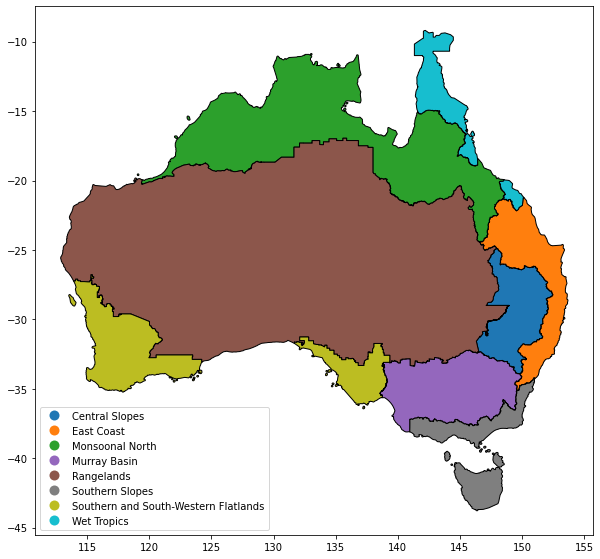

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nrm_clusters.plot(
    ax=ax,
    column='label',
    legend=True,
    edgecolor='black',
    legend_kwds={'loc': 'lower left'}    
)
plt.show()

In [118]:
nrm_sub_clusters = gp.read_file('/g/data/xv83/dbi599/shapefiles/NRM_sub_clusters/NRM_sub_clusters.shp')
nrm_sub_clusters

,OBJECTID,C_code,C_Label,code,label,geometry
0,9,WT,Wet Tropics,WT,Wet Tropics,"MULTIPOLYGON (((150.17258 -21.24859, 150.09178..."
1,0,R,Rangelands,RN,Rangelands (North),"MULTIPOLYGON (((118.80797 -20.07215, 118.80600..."
2,0,MN,Monsoonal North,MNE,Monsoonal North (East),"POLYGON ((146.42400 -18.40860, 146.44167 -18.4..."
3,0,MN,Monsoonal North,MNW,Monsoonal North (West),"MULTIPOLYGON (((133.03730 -10.85283, 133.03836..."
4,0,EC,East Coast,ECS,East Coast (South),"POLYGON ((151.03053 -34.27589, 151.03053 -34.2..."
5,0,CS,Central Slopes,CS,Central Slopes,"POLYGON ((147.95700 -24.87855, 147.95711 -24.8..."
6,0,MB,Murray Basin,MB,Murray Basin,"MULTIPOLYGON (((140.96606 -38.10852, 140.96606..."
7,0,SSWF,Southern and South Western Flatlands,SSWFW,Southern and South Western Flatlands (West),"MULTIPOLYGON (((121.99574 -34.52416, 121.99376..."
8,0,SSWF,Southern and South Western Flatlands,SSWFE,Southern and South Western Flatlands (East),"MULTIPOLYGON (((137.32870 -36.29796, 137.32916..."
9,0,SS,Southern Slopes,SSVE,Southern Slopes (Vic/NSW East),"MULTIPOLYGON (((147.09424 -39.19847, 147.06241..."


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


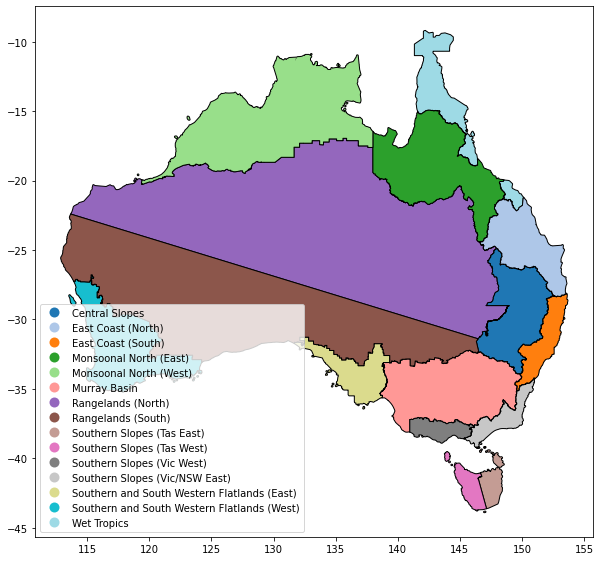

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nrm_sub_clusters.plot(
    ax=ax,
    column='label',
    legend=True,
    edgecolor='black',
    cmap='tab20',
    legend_kwds={'loc': 'lower left'}    
)
plt.show()

In [120]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

## Get NorESM2-MM data

In [121]:
noresm_dates = ['19900101-19991231', '20000101-20091231', '20100101-20141231']
noresm_pr_files = [f'/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_{dates}.nc' for dates in noresm_dates]
noresm_pr_files

['/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_19900101-19991231.nc',
 '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_20000101-20091231.nc',
 '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_20100101-20141231.nc']

In [122]:
noresm_ds = xr.open_mfdataset(noresm_pr_files)
noresm_ds = noresm_ds.sel({'time': slice(start_date, end_date)})

In [123]:
noresm_ds['pr'] = noresm_ds['pr'] * 86400
noresm_ds['pr'].attrs['units'] = 'mm' 

In [124]:
noresm_annual_totals = noresm_ds.resample({'time': 'A'}).sum('time', keep_attrs=True)
noresm_annual_clim = noresm_annual_totals.mean('time', keep_attrs=True)
noresm_monthly_clim = noresm_ds.groupby('time.month').mean('time', keep_attrs=True)

## Get AGCD data

In [125]:
agcd_years = np.arange(1995, 2015, 1)
agcd_pr_files = [f'/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_{year}0101-{year}1231_daily.nc' for year in agcd_years]
agcd_pr_files

['/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19950101-19951231_daily.nc',
 '/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19960101-19961231_daily.nc',
 '/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19970101-19971231_daily.nc',
 '/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19980101-19981231_daily.nc',
 '/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19990101-19991231_daily.nc',
 '/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20000101-20001231_daily.nc',
 '/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20010101-20011231_daily.nc',
 '/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20020101-20021231_daily.nc',
 '/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20030101-20031231_daily.nc',
 '/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20040101-20041231_daily.nc',
 '/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20050101-20051231_daily.nc',

In [126]:
agcd_ds = xr.open_mfdataset(agcd_pr_files)
agcd_ds = agcd_ds.sel({'time': slice(start_date, end_date)})

In [127]:
agcd_ds

<xarray.Dataset>
Dimensions:    (lon: 886, time: 7305, bnds: 2, lat: 691)
Coordinates:
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * time       (time) datetime64[ns] 1995-01-01T09:00:00 ... 2014-12-31T09:00:00
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (time, lon, bnds) float32 dask.array<chunksize=(365, 886, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float32 dask.array<chunksize=(365, 691, 2), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    precip     (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 15:00:26 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [128]:
agcd_annual_totals = agcd_ds.resample({'time': 'A'}).sum('time', keep_attrs=True)
agcd_annual_clim = agcd_annual_totals.mean('time', keep_attrs=True)
agcd_monthly_clim = agcd_ds.groupby('time.month').mean('time', keep_attrs=True)

In [129]:
agcd_annual_clim = spatial_selection.select_shapefile_regions(agcd_annual_clim, aus_shape)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  1min 21.8s
[########################################] | 100% Completed |  1min 21.9s
[########################################] | 100% Completed |  1min 22.0s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[#############################

In [130]:
agcd_monthly_clim = spatial_selection.select_shapefile_regions(agcd_monthly_clim, aus_shape)

[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1min 23.0s
[########################################] | 100% Completed |  1min 23.0s
[########################################] | 100% Completed |  1min 23.1s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s
[#############################

In [131]:
noresm_regridder = xe.Regridder(noresm_ds, agcd_ds, "bilinear")

In [132]:
noresm_annual_clim = noresm_regridder(noresm_annual_clim)
noresm_monthly_clim = noresm_regridder(noresm_monthly_clim)

In [133]:
noresm_annual_clim = spatial_selection.select_shapefile_regions(noresm_annual_clim, aus_shape)

[########################################] | 100% Completed | 12.6s
[########################################] | 100% Completed | 12.7s
[########################################] | 100% Completed | 12.8s
[########################################] | 100% Completed | 11.3s
[########################################] | 100% Completed | 11.4s
[########################################] | 100% Completed | 11.5s


In [134]:
noresm_monthly_clim = spatial_selection.select_shapefile_regions(noresm_monthly_clim, aus_shape)

[########################################] | 100% Completed | 11.9s
[########################################] | 100% Completed | 12.0s
[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.2s


## Mean bias

In [135]:
noresm_annual_clim = noresm_annual_clim.compute()

[########################################] | 100% Completed | 11.5s
[########################################] | 100% Completed | 11.5s
[########################################] | 100% Completed | 11.6s


In [136]:
agcd_annual_clim = agcd_annual_clim.compute()

[########################################] | 100% Completed |  1min 22.3s
[########################################] | 100% Completed |  1min 22.4s
[########################################] | 100% Completed |  1min 22.5s


In [137]:
noresm_annual_clim

<xarray.Dataset>
Dimensions:  (lat: 656, lon: 814)
Coordinates:
  * lon      (lon) float32 112.9 113.0 113.1 113.1 ... 153.4 153.5 153.6 153.6
  * lat      (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.2 -10.15 -10.1
Data variables:
    pr       (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    regrid_method:  bilinear

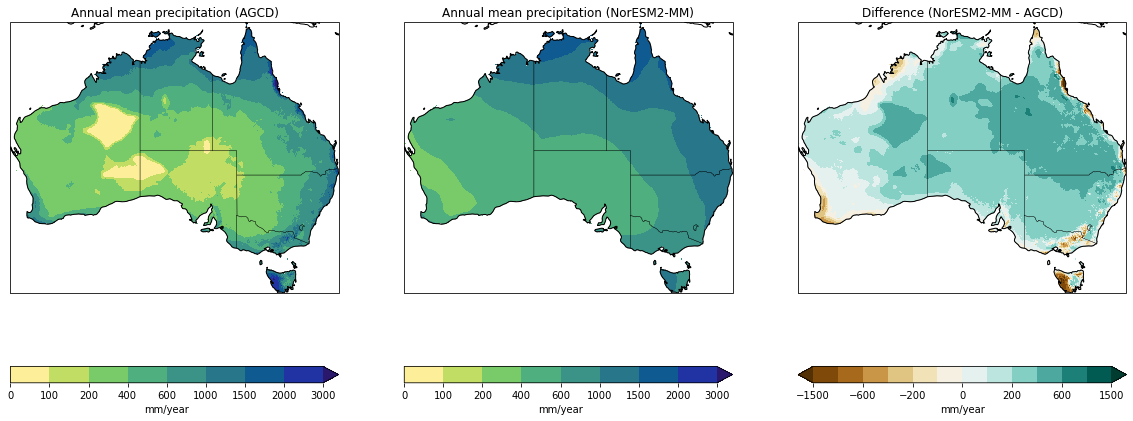

In [143]:
fig = plt.figure(figsize=[20, 9])

noresm_max = np.nanmax(noresm_annual_clim['pr'].values)
agcd_max = np.nanmax(agcd_annual_clim['precip'].values)
vmax = np.nanmax([noresm_max, agcd_max])

noresm_min = np.nanmin(noresm_annual_clim['pr'].values)
agcd_min = np.nanmin(agcd_annual_clim['precip'].values)
vmin = np.nanmin([noresm_min, agcd_min])

levels = [0, 100, 200, 400, 600, 1000, 1500, 2000, 3000]

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
agcd_annual_clim['precip'].plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.haline_r,
    levels=levels,
    extend='max',
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'mm/year'}
)
ax1.set_title('Annual mean precipitation (AGCD)')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
noresm_annual_clim['pr'].plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.haline_r,
    levels=levels,
    extend='max',
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'mm/year'}
)
ax2.set_title('Annual mean precipitation (NorESM2-MM)')

diff = noresm_annual_clim['pr'] - agcd_annual_clim['precip']
ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
diff.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap='BrBG',
    levels=[-1500, -1000, -600, -400, -200, -100, 0, 100, 200, 400, 600, 1000, 1500],
    extend='both',
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'mm/year'}
)
ax3.set_title('Difference (NorESM2-MM - AGCD)')

for ax in [ax1, ax2, ax3]:
    #ax.add_geometries(nrm_shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black')
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES, linewidth=0.3)
    #ax.spines['top'].set_visible(False)

#plt.suptitle(title)
plt.show()

## Temporal 

In [145]:
noresm_monthly_clim = noresm_monthly_clim.compute()

[########################################] | 100% Completed | 13.1s
[########################################] | 100% Completed | 13.1s
[########################################] | 100% Completed | 13.2s


In [146]:
agcd_monthly_clim = agcd_monthly_clim.compute()

[########################################] | 100% Completed |  1min 26.8s
[########################################] | 100% Completed |  1min 26.9s
[########################################] | 100% Completed |  1min 27.0s


In [147]:
temporal_corr = xr.corr(noresm_monthly_clim['pr'], agcd_monthly_clim['precip'], dim='month') 

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [148]:
noresm_temporal_std = noresm_monthly_clim['pr'].std(dim='month', keep_attrs=True)
agcd_temporal_std = agcd_monthly_clim['precip'].std(dim='month', keep_attrs=True)
std_ratio = noresm_temporal_std / agcd_temporal_std

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


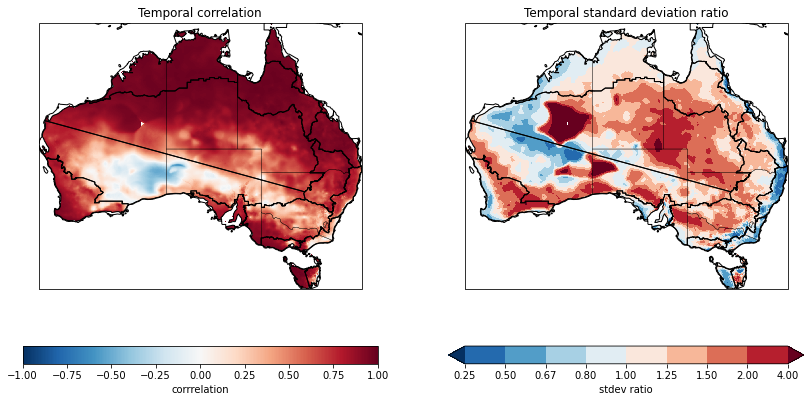

In [149]:
fig = plt.figure(figsize=[14, 7])

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
temporal_corr.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmax=1,
    vmin=-1,
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'corrrelation'}
)
ax1.set_title('Temporal correlation')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
std_ratio.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    levels=[0.25, 0.5, 0.67, 0.8, 1.0, 1.25, 1.5, 2.0, 4.0],
    extend='both',
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'stdev ratio'}
)
ax2.set_title('Temporal standard deviation ratio')

for ax in [ax1, ax2]:
    ax.coastlines()
    ax.add_geometries(nrm_sub_clusters.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black')
    ax.add_feature(cartopy.feature.STATES, linewidth=0.3)
#plt.suptitle(title)
plt.show()

In [60]:
noresm_monthly_clim_nrm_sub_clusters = spatial_selection.select_shapefile_regions(
noresm_monthly_clim,
    nrm_sub_clusters,
    agg='weighted_mean',
    header='label'
)
noresm_monthly_clim_nrm_sub_clusters

<xarray.Dataset>
Dimensions:  (month: 12, region: 15)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region   (region) <U43 'Wet Tropics' ... 'Rangelands (South)'
Data variables:
    pr       (month, region) float64 9.754 3.597 8.452 ... 2.05 4.331 1.089
Attributes:
    regrid_method:  bilinear

In [61]:
agcd_monthly_clim_nrm_sub_clusters = spatial_selection.select_shapefile_regions(
    agcd_monthly_clim,
    nrm_sub_clusters,
    agg='weighted_mean',
    header='label'
)
agcd_monthly_clim_nrm_sub_clusters

<xarray.Dataset>
Dimensions:   (month: 12, region: 15, bnds: 2)
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region    (region) <U43 'Wet Tropics' ... 'Rangelands (South)'
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (month, bnds, region) float32 143.8 133.8 143.1 ... 150.1 127.1
    lat_bnds  (month, bnds, region) float32 -14.93 -23.66 ... -24.62 -28.78
    precip    (month, region) float32 11.07 2.071 6.536 ... 3.838 3.582 0.7615
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 15:00:26 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

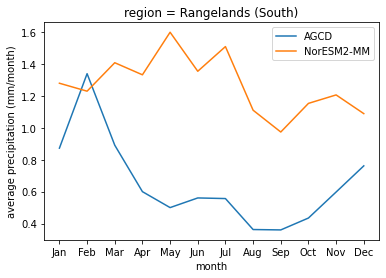

In [151]:
agcd_monthly_clim_nrm_sub_clusters['precip'].sel({'region': 'Rangelands (South)'}).plot(label='AGCD')
noresm_monthly_clim_nrm_sub_clusters['pr'].sel({'region': 'Rangelands (South)'}).plot(label='NorESM2-MM')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
plt.xticks(xticks, xlabels)
plt.legend()
plt.ylabel('average precipitation (mm/month)')
plt.show()

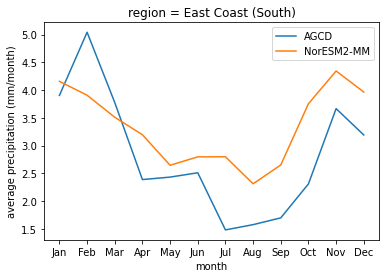

In [152]:
agcd_monthly_clim_nrm_sub_clusters['precip'].sel({'region': 'East Coast (South)'}).plot(label='AGCD')
noresm_monthly_clim_nrm_sub_clusters['pr'].sel({'region': 'East Coast (South)'}).plot(label='NorESM2-MM')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
plt.xticks(xticks, xlabels)
plt.legend()
plt.ylabel('average precipitation (mm/month)')
plt.show()

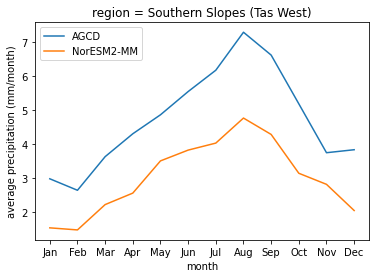

In [150]:
agcd_monthly_clim_nrm_sub_clusters['precip'].sel({'region': 'Southern Slopes (Tas West)'}).plot(label='AGCD')
noresm_monthly_clim_nrm_sub_clusters['pr'].sel({'region': 'Southern Slopes (Tas West)'}).plot(label='NorESM2-MM')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
plt.xticks(xticks, xlabels)
plt.legend()
plt.ylabel('average precipitation (mm/month)')
plt.show()

## Spatial

In [71]:
noresm_spatial_corr = xr.corr(noresm_monthly_clim['pr'], agcd_monthly_clim['precip'], dim=['lat', 'lon']) 

In [72]:
noresm_spatial_corr

<xarray.DataArray (month: 12)>
array([0.92008118, 0.85059206, 0.87454718, 0.78859853, 0.75766313,
       0.78198018, 0.76712115, 0.74236491, 0.68725035, 0.61140822,
       0.8232583 , 0.86618163])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [73]:
noresm_spatial_corr_ave = float(noresm_spatial_corr.mean('month'))
noresm_spatial_corr_ave

0.7892539021896448

In [74]:
noresm_spatial_std = noresm_monthly_clim['pr'].std(dim=['lat', 'lon'], keep_attrs=True)
noresm_spatial_std

<xarray.DataArray 'pr' (month: 12)>
array([2.94132336, 3.0309381 , 2.07081113, 0.87126055, 0.45170025,
       0.67475292, 0.70992041, 0.72322382, 0.75963257, 0.8167527 ,
       1.28663438, 1.95276282])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [75]:
noresm_spatial_std_ave = float(noresm_spatial_std.mean('month'))
noresm_spatial_std_ave

1.3574760850992975

In [76]:
agcd_spatial_std = agcd_monthly_clim['precip'].std(dim=['lat', 'lon'], keep_attrs=True)
agcd_spatial_std

<xarray.DataArray 'precip' (month: 12)>
array([2.812696  , 2.9746323 , 2.1929877 , 0.91121686, 0.71021247,
       0.8687613 , 0.85971755, 0.90219307, 0.8163974 , 0.6724649 ,
       0.9364734 , 1.795494  ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:                 lwe_thickness_of_precipitation_amount
    long_name:                     Daily precipitation
    units:                         mm
    cell_methods:                  time: sum
    analysis_version_number:       3.01
    number_of_stations_reporting:  6198
    source:                        Interpolated surface observations
    frequency:                     daily
    length_scale_for_analysis:     80.0
    analysis_time:                 2010-08-02 22:53:32 UTC

In [77]:
agcd_spatial_std_ave = float(agcd_spatial_std.mean('month'))
agcd_spatial_std_ave

1.3711038827896118

In [78]:
noresm_spatial_std_ratio = noresm_spatial_std_ave / agcd_spatial_std_ave
noresm_spatial_std_ratio

0.9900607110362873

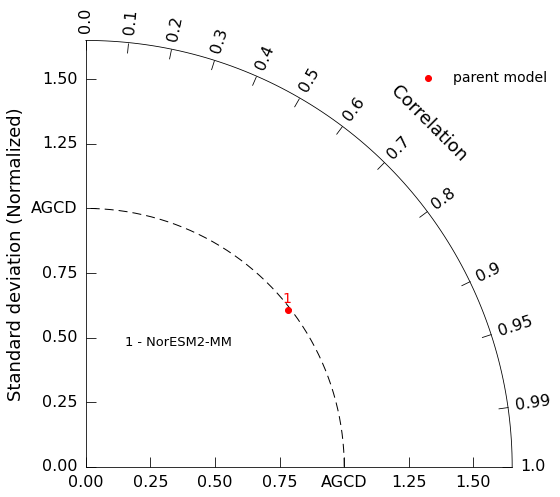

In [80]:
# parent models
parent_std_ratios = [noresm_spatial_std_ratio]
parent_corrs = [noresm_spatial_corr_ave]

# CCAM data
ccam_std_ratios = []
ccam_corrs = []

# BARPA data
barpa_std_ratios = []
barpa_corrs = []

# Create figure and TaylorDiagram instance
fig = plt.figure(figsize=(8, 8))
dia = TaylorDiagram(fig=fig, label='AGCD')

# Add parent models to Taylor diagram
dia.add_model_set(
    parent_std_ratios,
    parent_corrs,
    color='red',
    marker='o',
    label='parent model'
)

namearr = ['NorESM2-MM']
dia.add_model_name(namearr)
dia.add_legend()
plt.show()